# Co occurrence exploration
Exploring what dishes appear together in reviews

Data and Library importing

In [1]:
%load_ext autoreload
%autoreload 2

import json
from collections import defaultdict, Counter


#General-Purpose
import pandas as pd
import numpy as np
import re
import nltk
from tqdm import tqdm



#Visualization
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

#pandas and numpy for df manipulation
import pandas as pd
import re
import nltk
nltk.download('averaged_perceptron_tagger_eng')


import spacy
from spacy import displacy

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [49]:
reviews = pd.read_csv(r'D:\MARGARIDA\dificuldade\3rd_year\TM project\Hyderabadi-Word-Soup\data_hyderabad\10k_reviews.csv')
restaurants = pd.read_csv(r'D:\MARGARIDA\dificuldade\3rd_year\TM project\Hyderabadi-Word-Soup\data_hyderabad\105_restaurants.csv')

## Processing data for NER

In [50]:
def regex_cleaner(raw_text, 
                  no_emojis = True, 
                  no_hashtags = True,
                  hashtag_retain_words = True,
                  no_newlines = True,
                  no_urls = True,
                  no_punctuation = True,
                  no_numbers = True):
    
    # Convert text to lowercase
    raw_text = raw_text.lower()
    
    newline_pattern = "(\\n)"
    hashtags_at_pattern = "([#\@@\u0040\uFF20\uFE6B])"
    hashtags_ats_and_word_pattern = "([#@]\w+)"
    emojis_pattern = "([\u2600-\u27FF])"
    url_pattern = "(?:\w+:\/{2})?(?:www)?(?:\.)?([a-z\d]+)(?:\.)([a-z\d\.]{2,})(\/[a-zA-Z\/\d]+)?" 
    punctuation_pattern = "[\u0021-\u0026\u0028-\u002C\u002E-\u002F\u003A-\u003F\u005B-\u005F\u2010-\u2028\ufeff`]+"
    apostrophe_pattern = "'(?=[A-Z\s])|(?<=[a-z\.\?\!\,\s])'"
    separated_words_pattern = "(?<=\w\s)([A-Z]\s){2,}"
    number_pattern = "[-+]?\d*\.?\d+"
    
    if no_emojis == True:
        clean_text = re.sub(emojis_pattern,"",raw_text)
    else:
        clean_text = raw_text

    if no_hashtags == True:
        if hashtag_retain_words == True:
            clean_text = re.sub(hashtags_at_pattern,"",clean_text)
        else:
            clean_text = re.sub(hashtags_ats_and_word_pattern,"",clean_text)
        
    if no_newlines == True:
        clean_text = re.sub(newline_pattern," ",clean_text)

    if no_urls == True:
        clean_text = re.sub(url_pattern,"",clean_text)
    
    if no_punctuation == True:
        clean_text = re.sub(punctuation_pattern,"",clean_text)
        clean_text = re.sub(apostrophe_pattern,"",clean_text)

    if no_numbers == True:
        clean_text = re.sub(number_pattern,"",clean_text)

    return clean_text

In [51]:
reviews.drop(['Reviewer', 'Metadata', 'Time', 'Pictures', 'Rating'], axis=1, inplace=True)
reviews.dropna(subset=['Review'], inplace=True)

restaurants.drop(['Links', 'Cost', 'Collections', 'Timings'], axis=1, inplace=True)
restaurants.dropna(subset=['Name', 'Cuisines'], inplace=True)

# Merges the cuisines column with the reviews
reviews = reviews.merge(restaurants[['Name', 'Cuisines']], 
                                      left_on='Restaurant', right_on='Name', 
                                      how='left').drop(columns=['Name'])

reviews.drop(['Restaurant'], axis=1, inplace=True)

reviews.head()

,Review,Cuisines
0,"The ambience was good, food was quite good . h...","Chinese, Continental, Kebab, European, South I..."
1,Ambience is too good for a pleasant evening. S...,"Chinese, Continental, Kebab, European, South I..."
2,A must try.. great food great ambience. Thnx f...,"Chinese, Continental, Kebab, European, South I..."
3,Soumen das and Arun was a great guy. Only beca...,"Chinese, Continental, Kebab, European, South I..."
4,Food is good.we ordered Kodi drumsticks and ba...,"Chinese, Continental, Kebab, European, South I..."


In [52]:
reviews["review_clean"] =\
      reviews["Review"].apply(lambda content :\
                                                  regex_cleaner(content))
reviews.head()

,Review,Cuisines,review_clean
0,"The ambience was good, food was quite good . h...","Chinese, Continental, Kebab, European, South I...",the ambience was good food was quite good had...
1,Ambience is too good for a pleasant evening. S...,"Chinese, Continental, Kebab, European, South I...",ambience is too good for a pleasant evening se...
2,A must try.. great food great ambience. Thnx f...,"Chinese, Continental, Kebab, European, South I...",a must try great food great ambience thnx for ...
3,Soumen das and Arun was a great guy. Only beca...,"Chinese, Continental, Kebab, European, South I...",soumen das and arun was a great guy only becau...
4,Food is good.we ordered Kodi drumsticks and ba...,"Chinese, Continental, Kebab, European, South I...",food is ordered kodi drumsticks and basket mu...


In [53]:
'''#tokenizes on whitespaces - gaps=True means it will split on the regex pattern
regex_tokenizer_1 = RegexpTokenizer(r'\s+', gaps=True)
reviews["preproc_content"] = reviews["review_clean"].apply(lambda content : regex_tokenizer_1.tokenize(str(content)))


reviews'''

'#tokenizes on whitespaces - gaps=True means it will split on the regex pattern\nregex_tokenizer_1 = RegexpTokenizer(r\'\\s+\', gaps=True)\nreviews["preproc_content"] = reviews["review_clean"].apply(lambda content : regex_tokenizer_1.tokenize(str(content)))\n\n\nreviews'

## Using spacy

Using spacy as a solution for Named Entity Recognition

In [57]:
#loading spacy 
nlp = spacy.load("en_core_web_sm")


In [68]:
def perform_ner(text):
    '''
    Performs named entity recognition using Spacy. 
    Returns a string with every noun word, except those labeled as "outside" / "O", separated by a whitespace.
    args: 
        text (string) : text to perform the operation on
    returns:
        string 
    '''
    doc = nlp(text)
    # Keep only nouns with entity labels
    filtered_words = [token.text for token in doc if token.ent_type_ != "" and token.pos_ == "NOUN"]
    return filtered_words



In [70]:
reviews["filtered_review"] = reviews["review_clean"].apply(perform_ner)

In [71]:
reviews

,Review,Cuisines,review_clean,filtered_review
0,"The ambience was good, food was quite good . h...","Chinese, Continental, Kebab, European, South I...",the ambience was good food was quite good had...,[]
1,Ambience is too good for a pleasant evening. S...,"Chinese, Continental, Kebab, European, South I...",ambience is too good for a pleasant evening se...,[]
2,A must try.. great food great ambience. Thnx f...,"Chinese, Continental, Kebab, European, South I...",a must try great food great ambience thnx for ...,[]
3,Soumen das and Arun was a great guy. Only beca...,"Chinese, Continental, Kebab, European, South I...",soumen das and arun was a great guy only becau...,[]
4,Food is good.we ordered Kodi drumsticks and ba...,"Chinese, Continental, Kebab, European, South I...",food is ordered kodi drumsticks and basket mu...,[biryani]
...,...,...,...,...
9950,Madhumathi Mahajan Well to start with nice cou...,"Chinese, Seafood",madhumathi mahajan well to start with nice cou...,[months]
9951,This place has never disappointed us.. The foo...,"Chinese, Seafood",this place has never disappointed us the food ...,[]
9952,"Bad rating is mainly because of ""Chicken Bone ...","Chinese, Seafood",bad rating is mainly because of chicken bone f...,"[noon, thrusday]"
9953,I personally love and prefer Chinese Food. Had...,"Chinese, Seafood",i personally love and prefer chinese food had ...,[]


### Co-occurence

In [42]:
def cooccurrence_matrix_window_generator(preproc_sentences, window_size):

    co_occurrences = defaultdict(Counter)

    # Compute co-occurrences
    for sentence in tqdm(preproc_sentences):
        for i, word in enumerate(sentence):
            for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)):
                if i != j:
                    co_occurrences[word][sentence[j]] += 1

    #ensure that words are unique
    unique_words = list(set([word for sentence in preproc_sentences for word in sentence]))

    # Initialize the co-occurrence matrix
    co_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=int)

    # Populate the co-occurrence matrix
    word_index = {word: idx for idx, word in enumerate(unique_words)}
    for word, neighbors in co_occurrences.items():
        for neighbor, count in neighbors.items():
            co_matrix[word_index[word]][word_index[neighbor]] = count

    # Create a DataFrame for better readability
    co_matrix_df = pd.DataFrame(co_matrix, index=unique_words, columns=unique_words)

    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=1)
    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=0)

    # Return the co-occurrence matrix
    return co_matrix_df

In [72]:
reviews_food_co_occurence = cooccurrence_matrix_window_generator(reviews["filtered_review"].tolist(),1)

100%|██████████| 9955/9955 [00:00<00:00, 859849.59it/s]


In [73]:
reviews_food_co_occurence

,biryani,day,night,evening,today,masala,hours,paneer,hour,weekend,...,bread,tuesday,contacte,lotus,cart,pizzaas,thght,towers,restaurant,parthou
biryani,140,10,8,6,4,6,2,4,1,2,...,0,0,0,0,0,0,0,0,0,0
day,10,26,8,4,4,1,2,2,3,2,...,0,0,0,0,0,0,0,0,0,0
night,8,8,36,8,3,0,7,0,3,6,...,0,0,0,0,0,0,0,0,0,0
evening,6,4,8,6,2,0,9,0,4,2,...,0,0,0,0,0,0,0,0,0,0
today,4,4,3,2,12,1,0,2,5,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
louge,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samosas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fassos,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
🤣,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Visualising co-occurence

1 word context window

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\utils.py:61: UserWarning:

Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from current font.

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from current font.



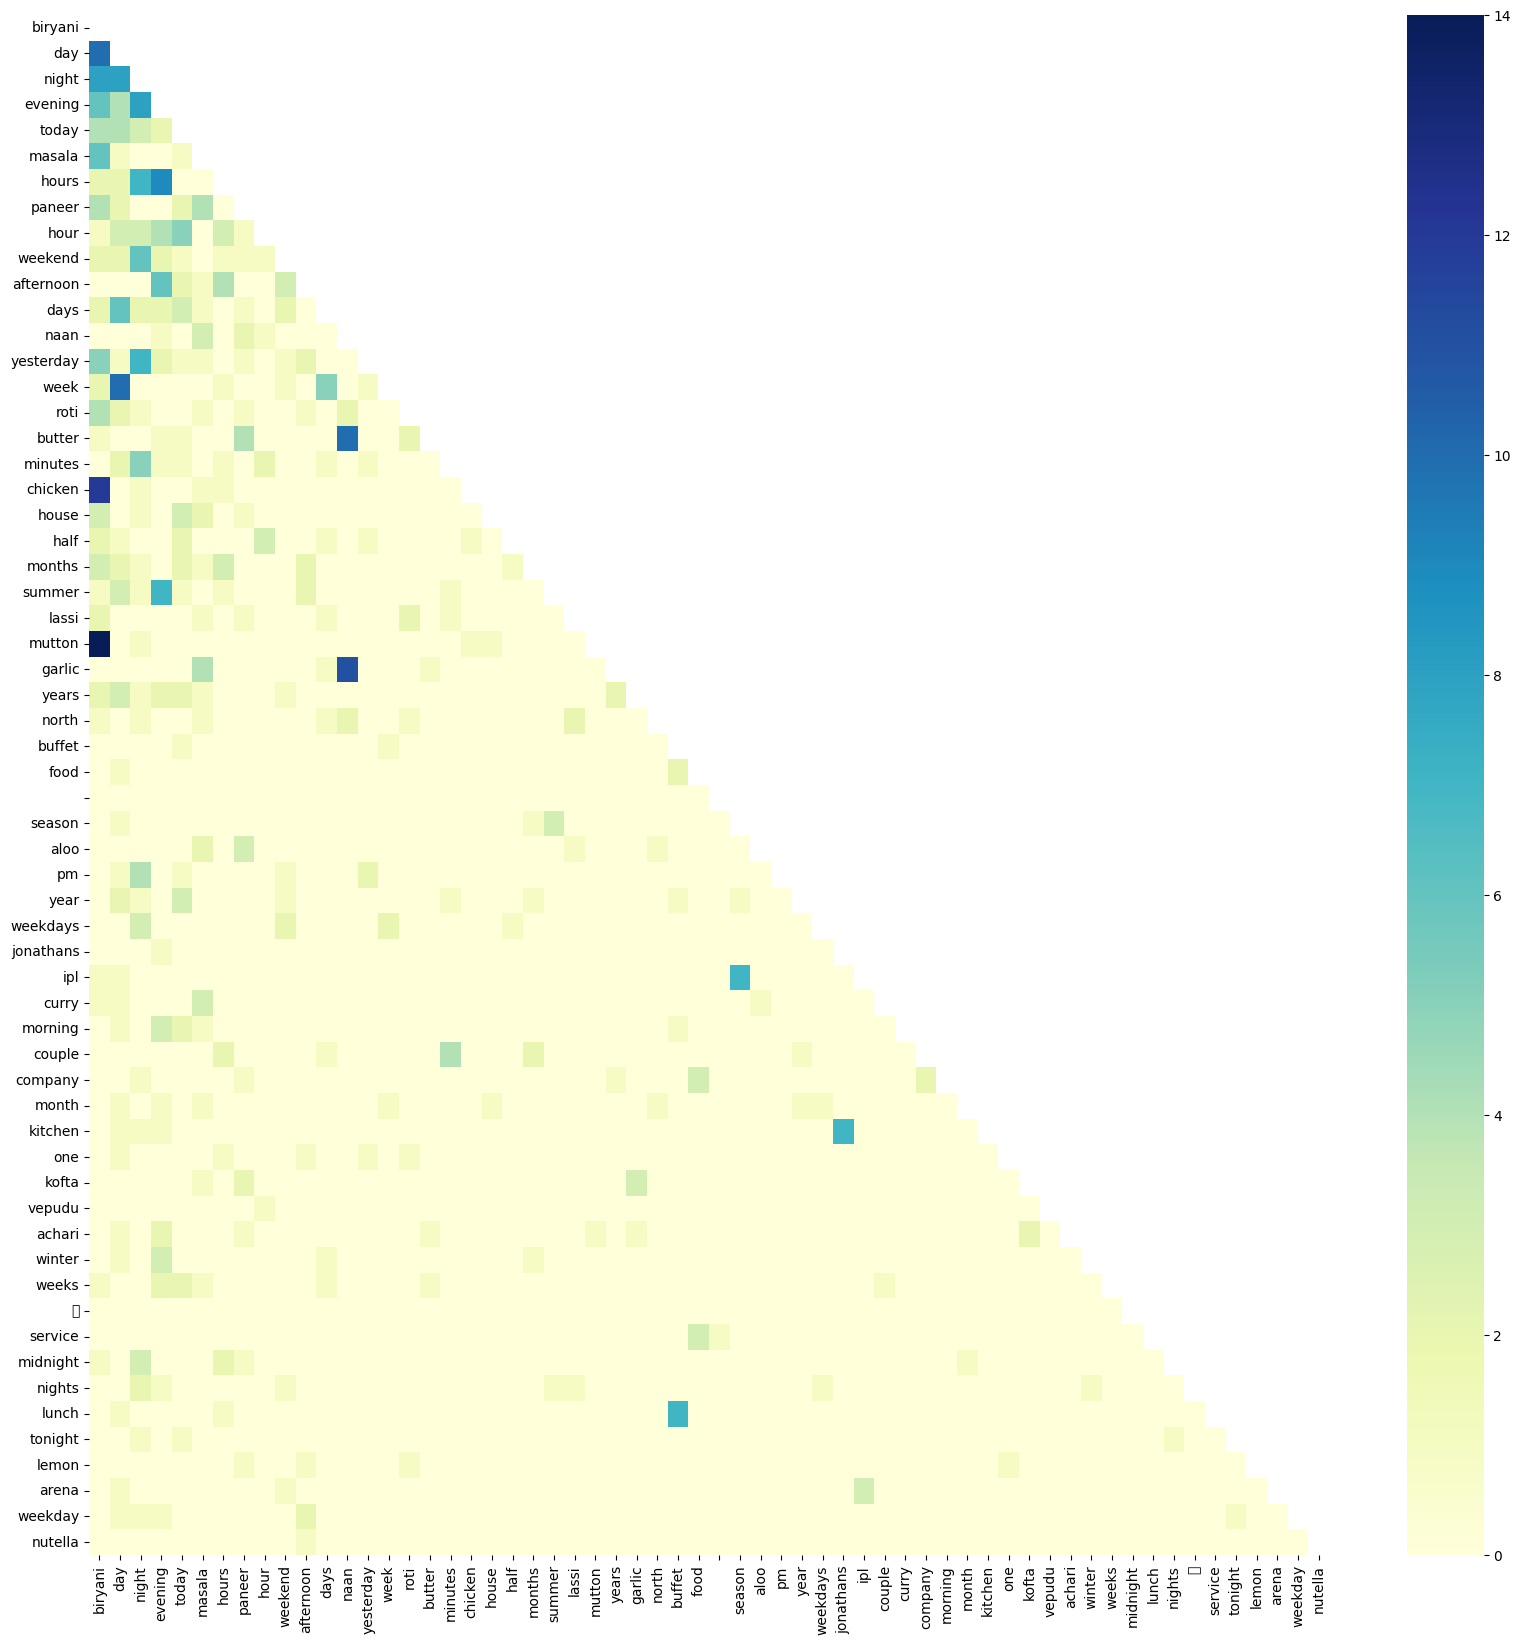

In [74]:
# Create a mask for the upper triangle, but leave the diagonal elements as True
mask = np.triu(np.ones_like(reviews_food_co_occurence.iloc[:60, :60], dtype=bool))

# Create heatmap from the co-occurrence matrix using 
plt.figure(figsize=(20,20))
sns.heatmap(reviews_food_co_occurence.iloc[:60, :60], cmap="YlGnBu", mask=mask)
plt.show()

2 word context window

In [76]:
reviews_food_co_occurence_2 = cooccurrence_matrix_window_generator(reviews["filtered_review"].tolist(),2)

fig = px.imshow(reviews_food_co_occurence_2.iloc[:60, :60], color_continuous_scale='YlGnBu', 
                labels=dict(x="Words", y="Words", color="Count"),
                title="Co-occurrence matrix for The Two Towers (60 most frequent co-occurring words in a 2-token context window)", 
                width=1200, height=1200)

fig.show()


100%|██████████| 9955/9955 [00:00<00:00, 763248.94it/s]


#### Network graph

In [26]:
def cooccurrence_network_generator(cooccurrence_matrix_df, n_highest_words, output=None):
    
    filtered_df = cooccurrence_matrix_df.iloc[:n_highest_words, :n_highest_words]
    graph = nx.Graph()

    # Add nodes for words and set their sizes based on frequency
    for word in filtered_df.columns:
        graph.add_node(word, size=filtered_df[word].sum())

    # Add weighted edges to the graph based on co-occurrence frequency
    for word1 in filtered_df.columns:
        for word2 in filtered_df.columns:
            if word1 != word2:
                graph.add_edge(word1, word2, weight=filtered_df.loc[word1, word2])

    figure = plt.figure(figsize=(14, 12))

    # Generate positions for the nodes
    pos = nx.spring_layout(graph, k=0.5)

    # Calculate edge widths based on co-occurrence frequency
    edge_weights = [0.1 * graph[u][v]['weight'] for u, v in graph.edges()]

    # Get node sizes based on the frequency of words
    node_sizes = [data['size'] * 2 for _, data in graph.nodes(data=True)]

    # Create the network graph
    nx.draw_networkx_nodes(graph, pos, node_color='skyblue', node_size=node_sizes)
    nx.draw_networkx_edges(graph, pos, edge_color='gray', width=edge_weights)
    nx.draw_networkx_labels(graph, pos, font_weight='bold', font_size=12)

    plt.show() 

    if output=="return":
        return figure

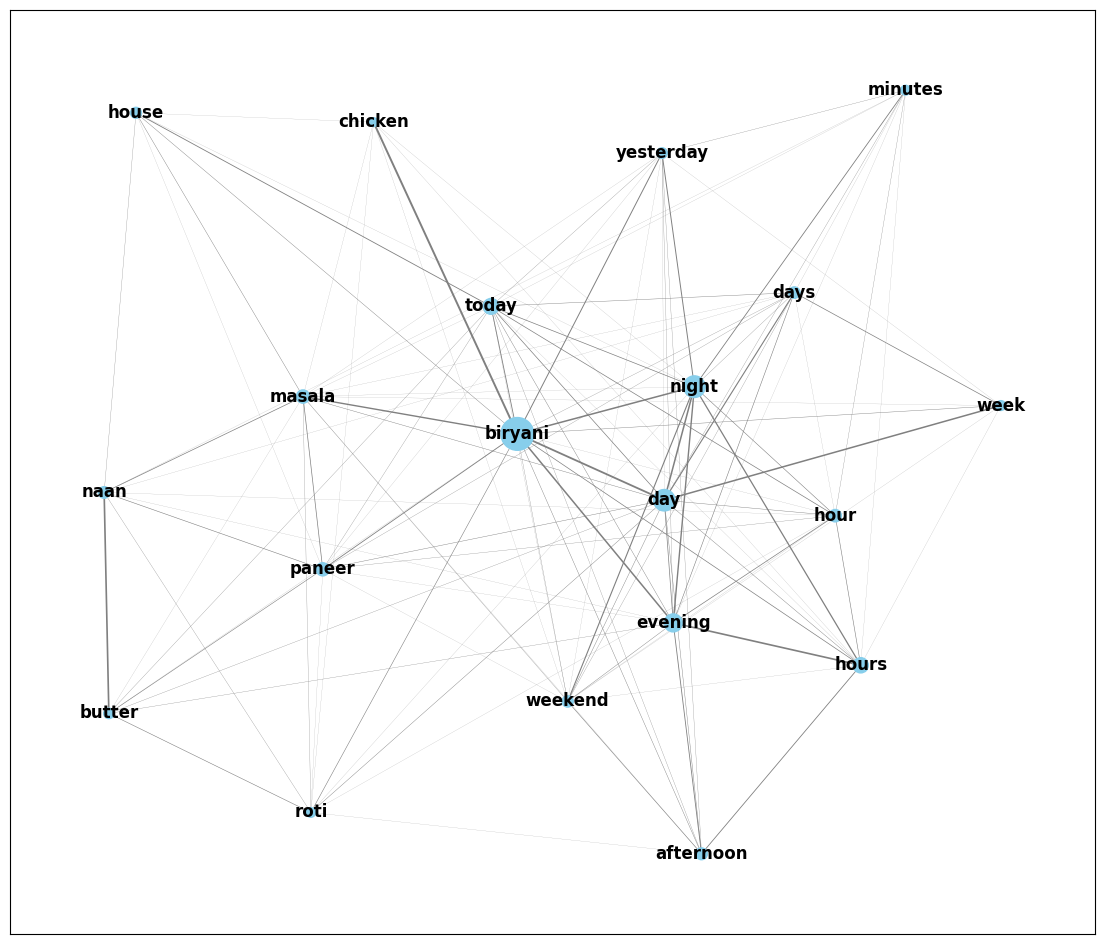

In [77]:
cooccurrence_network_generator(reviews_food_co_occurence_2, 20)

## Training and using a CRF model

Using a CRF model trained with external data

In [7]:
# Load the JSON data (replace 'data.json' with your JSON file's path)
with open(r'D:\MARGARIDA\dificuldade\3rd_year\TM project\Hyderabadi-Word-Soup\coocurrence_clustering\database.json', 'r') as file:
    json_data = json.load(file)

# Transform the JSON data into a DataFrame
food_db = pd.DataFrame(json_data)

# Select and rename columns as required
food_db = food_db[['text', 'entityType', 'uid']].rename(columns={'entityType': 'token'})


#Changing the NNP POS tag to "food"
food_db["token"] = "FOOD"
food_db



,text,token,uid
0,apple,FOOD,food
1,mango,FOOD,food
2,grapes,FOOD,food
3,watermelon,FOOD,food
4,plum,FOOD,food
...,...,...,...
310,gingerbread,FOOD,food
311,swedish limpa,FOOD,food
312,simit,FOOD,food
313,almond flax bread,FOOD,food


In [6]:
with open(r'D:\MARGARIDA\dificuldade\3rd_year\TM project\Hyderabadi-Word-Soup\coocurrence_clustering\synthetic_data.json', 'r') as file:
    json_data = json.load(file)

# Transform the JSON data into a DataFrame
synthetic_db = pd.DataFrame(json_data)

# Select and rename columns as required
synthethic_db = synthetic_db[['text', 'entityType', 'uid']].rename(columns={'entityType': 'token'})


synthethic_db

,text,token,uid
0,waiter,PERSON,personnel
1,manager,PERSON,personnel
2,cashier,PERSON,personnel
3,chef,PERSON,personnel
4,restaurant chain,ORG,business
...,...,...,...
65,conference hall,FAC,location
66,VIP lounge,FAC,location
67,budget,MONEY,finance
68,change,MONEY,finance


Concatonating our datasets

In [ ]:
training_data = pd.concat(food_db, synthethic_db)

In [56]:
def word_to_features(word):
    return {
        "word": word["text"],
        "pos": word["entityType"],
    }


## Comparing Spcay and CRF